In [1]:
import logging
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
import sinn.histories as histories
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap
import sinn.optimize.gradient_descent as gd

import main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

In [2]:
import theano
import theano.tensor as T

In [3]:
source_datalen = 10 # Use 4 seconds of data
datalen = 8.0       # Amount of data to use for likelihood
burnin = 0.5        # Amount of data to discard from likelihood
mbatch_size = 100    # Batch size when computing likelihood / gradients

# Sample data trace

In [4]:
spikemodel = main.generate_spikes(datalen,
                                  filename='data/short_adap/fsgif_{}s_sin-input'
                                           .format(source_datalen))

2017-07-24 11:55:21,398 - root - INFO - Checking for precomputed data...
2017-07-24 11:55:22,410 - root - INFO - Precomputed data found. Skipping data generation


In [5]:
main.compute_spike_activity(max_len=burnin+datalen)

(<sinn.histories.Series at 0x7f4e9d222b38>,
 <sinn.histories.Series at 0x7f4e9d222e80>)

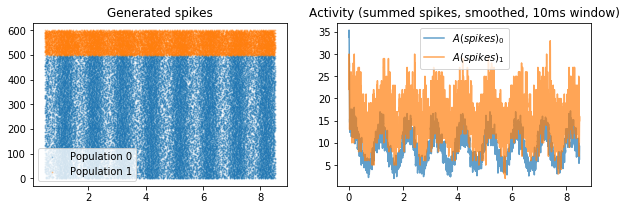

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen)

plt.subplot(1,2,2)
main.plot_spike_activity()

In [7]:
sinn.inputs.clear()

main.load_theano()

In [8]:
main.loaded['spike activity']['Ahist'].unlock()
main.loaded['spike activity']['Ihist'].unlock()
main.loaded['spike activity']['Ahist'].theano_reset()
main.loaded['spike activity']['Ihist'].theano_reset()
main.loaded['spike activity']['Ahist'].lock()
main.loaded['spike activity']['Ihist'].lock()
try:
    mfmodelT.theano_reset()
    mfmodelT.clear_unlocked_histories()
except NameError:
    pass
mfmodelT = main.derive_mf_model_from_spikes()

2017-07-24 11:55:24,014 - root - INFO - Producing Theano mean-field model.
2017-07-24 11:55:33,595 - root - INFO - Theano model complete.


In [9]:
mfmodelT.theano_reset()
mfmodelT.clear_unlocked_histories()

2017-07-24 11:55:33,600 - theano_shim - INFO - Clearing Theano updates


# Fits (gradient descent)

In [14]:
basedir = "data/short_adap/fits/random_init/too_short_runs/"

In [15]:
import os

In [16]:
Key = namedtuple('Key', ('seed', 'batch', 'lr', 'suffix'))
def make_key(desc_tuple):
    if len(desc_tuple) == 3:
        desc_tuple += (None,)
    assert(len(desc_tuple) == 4)
    return Key(*desc_tuple)

In [17]:
sgds_initrnd = {}
for fname in os.listdir(basedir):
    if fname[:3] != "fit":
        continue
    keydict = {keyname: None for keyname in Key._fields}
    for keyname in keydict:
        stopidx = fname.find(keyname)
        if stopidx == -1:
            keydict[keyname] = None
        else:
            startidx = fname.rfind('_', 0, stopidx)
            keyval = fname[startidx+1:stopidx]
            if '-' in keyval:
                keydict[keyname] = float(keyval.replace('-', '.'))
            else:
                keydict[keyname] = int(keyval)
    # 'suffix' key
    if 'suffix' in keydict:
        extpos = fname.rfind('.')
        if fname[extpos-1] in '1234567890':
            suffixpos = fname.rfind('_', 0, extpos) + 1
            keydict['suffix'] = int(fname[suffixpos:extpos])
    key = Key(**keydict)
    sgds_initrnd[key] = gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam',
                               sgd_file = basedir + fname)

In [33]:
keytuples_initgt = [(0, 100, 0.005),  (100, 100, 0.005),  (200, 100, 0.005),  (300, 100, 0.005),
                    (0, 100, 0.0005), (100, 100, 0.0005), (200, 100, 0.0005), (300, 100, 0.0005),
                    (0, 500, 0.005),  (100, 500, 0.005),  (200, 500, 0.005),  (300, 500, 0.005)]
keys_initgt = [make_key(t) for t in keytuples_initgt]

In [34]:
keytuples_initrnd = [(0, 100, 0.0005, None)] + [(0, 100, 0.0005, i) for i in range(2,13)]
keys_initrnd = [make_key(t) for t in keytuples_initrnd]

In [31]:
sgds_initgt = {key: gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam', 
                           sgd_file = basedir + "fit_8s_{}lr_{:0>3}batch_{:0>3}seed.sir"
                                               .format(str(key.lr)[2:], key.batch, key.seed))
        for key in keys_initgt}

In [46]:
basedir = "data/short_adap/fits/random_init/"

In [47]:
filenames = []
for key in keys_initrnd:
    suffix = "" if key.repeat is None else "_" + str(key.repeat)
    filenames.append(basedir + "fit_8s_{}lr_{:0>3}batch_{:0>3}seed{}.sir"
                               .format(str(key.lr)[2:], key.batch, key.seed, suffix))

sgds_initrnd = {key: gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam', sgd_file = filename)
                for key, filename in zip(keys_initrnd, filenames)}

In [18]:
def plot_evol(sgds, lr, batch):
    plt.figure(figsize=(13, 3))
    
    plt.subplot(1,3,1)
    plt.title('$w_{EE}$ evolution')
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['w'][:,0,0])
    plt.xlabel("epoch")
    plt.ylabel("$w_{EE}$")
    plt.axhline(0.176, color='orange')
    
    plt.subplot(1,3,2)
    plt.title('$τ_{m,I}$ evolution')
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(10**(sgd.get_evol()['logτ_m'][:,1]))
    plt.xlabel('epoch')
    plt.ylabel('$τ_{m,I}$')
    plt.axhline(0.02, color='orange')
    
    plt.subplot(1,3,3)
    plt.title("log L evolution")
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['logL'])
    plt.xlabel("epoch")
    plt.ylabel("log L")

## learning rate: 0.005, batch size: 100

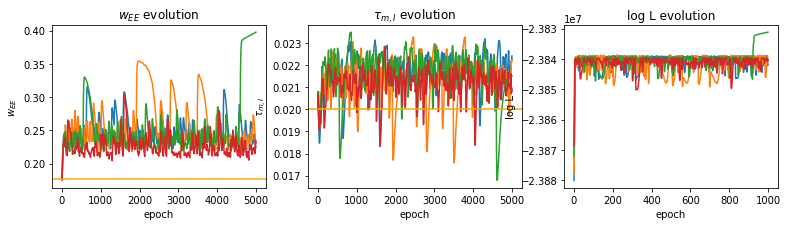

In [39]:
plot_evol(0.005, 100)

In [34]:
for key, sgd in sgds.items():
    if key.lr == 0.005 and key.batch == 100:
        sgd.verify_transforms()

Here are the transforms currently used:
τ_m -> logτ_m – (to) 'τ -> shim.log10(τ)', (from) 'logτ -> 10**logτ'
Press y to confirm that these transforms are not malicious.y
Here are the transforms currently used:
τ_m -> logτ_m – (to) 'τ -> shim.log10(τ)', (from) 'logτ -> 10**logτ'
Press y to confirm that these transforms are not malicious.y
Here are the transforms currently used:
τ_m -> logτ_m – (to) 'τ -> shim.log10(τ)', (from) 'logτ -> 10**logτ'
Press y to confirm that these transforms are not malicious.y
Here are the transforms currently used:
τ_m -> logτ_m – (to) 'τ -> shim.log10(τ)', (from) 'logτ -> 10**logτ'
Press y to confirm that these transforms are not malicious.y


(0, 1)

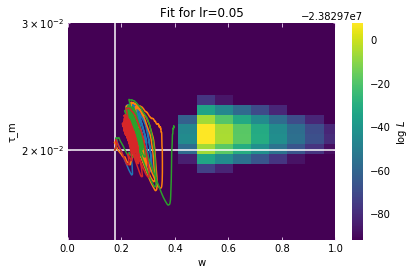

In [36]:
plt.title("Fit for lr=0.05")

anlz.plot(logL)
for key, sgd in sgds.items():
    if key.lr == 0.005 and key.batch == 100:
        sgd.plot_param_evol_overlay(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

plt.ylim((0.015, 0.03))
plt.xlim((0, 1))

## learning rate: 0.0005, batch size: 100

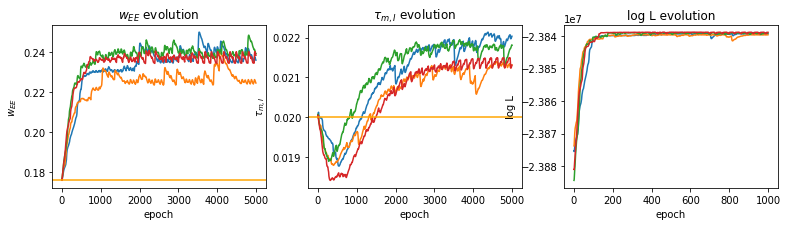

In [20]:
plot_evol(0.0005, 100)

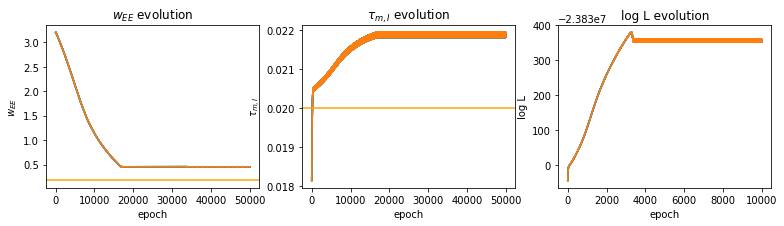

In [55]:
plot_evol(sgds_initrnd, 0.0005, 100)

In [19]:
logL = HeatMap.from_raw(io.loadraw("data/short_adap/fsgif_8s_sin-input_loglikelihood_theano.sir"))
logL.set_floor(logL.max()-100)

In [20]:
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.verify_transforms(trust_automatically=True)

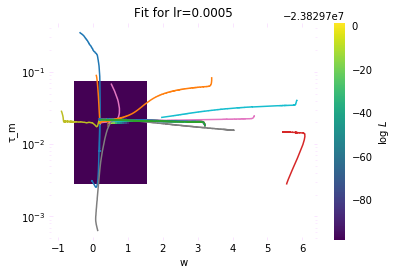

In [21]:
plt.title("Fit for lr=0.0005")

anlz.plot(logL)
#plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
#plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

#logL.set_ceil(logL[0.0:0.3, 0.015:0.03].max())
#logL.set_floor(logL[0.0:0.3, 0.015:0.03].min())

#for key, sgd in sgds_initgt.items():
#    if key.lr == 0.0005:
#        sgd.plot_param_evol_overlay(logL)
        
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.plot_param_evol_overlay(logL)

#plt.ylim((0.015, 0.03))
#plt.xlim((0, 1))

(0, 1)

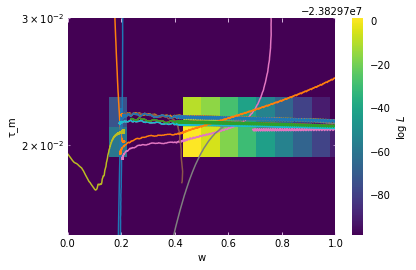

In [22]:
anlz.plot(logL)

for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.plot_param_evol_overlay(logL)

plt.ylim((0.015, 0.03))
plt.xlim((0, 1))

(0, 0.3)

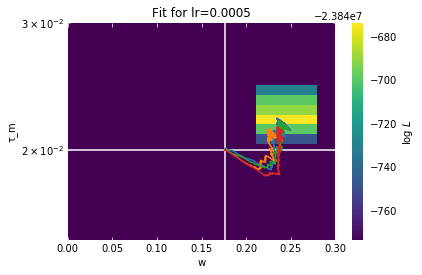

In [26]:
plt.title("Fit for lr=0.0005")

anlz.plot(logL)
for key, sgd in sgds.items():
    if key.lr == 0.0005:
        sgd.plot_param_evol_overlay(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

logL.set_ceil(logL[0.0:0.3, 0.015:0.03].max())
logL.set_floor(logL[0.0:0.3, 0.015:0.03].min())

plt.ylim((0.015, 0.03))
plt.xlim((0, 0.3))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3464554518>,
 <matplotlib.colorbar.Colorbar at 0x7f34644fb6a0>)

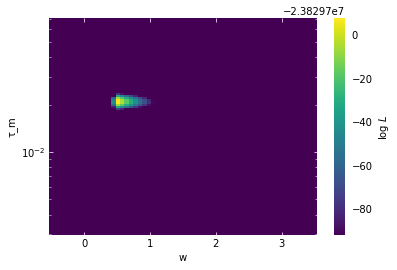

In [18]:
anlz.plot(logL)

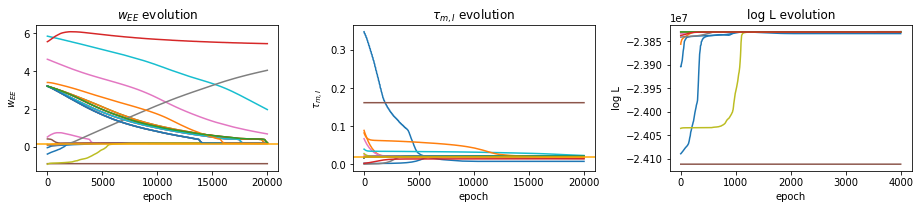

In [24]:
plot_evol(sgds_initrnd, lr=0.0005, batch=100)
plt.tight_layout()

In [28]:
sgd = list(sgds_initrnd.values())[0]

In [36]:
sgd.get_evol()['w']

array([[[-0.033, -0.702],
        [ 0.176, -0.702]],

       [[-0.033, -0.702],
        [ 0.176, -0.702]],

       [[-0.034, -0.702],
        [ 0.176, -0.702]],

       ..., 
       [[ 0.201, -0.702],
        [ 0.176, -0.702]],

       [[ 0.201, -0.702],
        [ 0.176, -0.702]],

       [[ 0.201, -0.702],
        [ 0.176, -0.702]]])

## learning rate: 0.005, batch size: 500

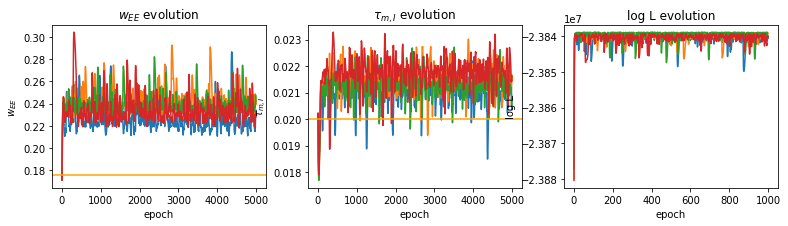

In [42]:
plot_evol(0.005, 500)